In [1]:
import mne
import pandas as pd
import numpy as np
from sklearn import cross_validation as cv
import matplotlib.pyplot as plt

from modelingtools import (delay_time_series, plot_cv_indices,
                           cross_validate_alpha)
import modelingtools

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale, StandardScaler
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_curve, roc_auc_score, r2_score
from sklearn.pipeline import make_pipeline, Pipeline

from itertools import product
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

/Users/choldgraf/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/choldgraf/anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Prediction and Validation
In the final tutorial, we will cover prediction and validation with encoding and decoding models. Ultimately, the point of a predictive model is to be able to make predictions about data is hasn't been trained on. Here will cover a few techniques that are useful for doing so.

# Setup

In [2]:
feature_path = '../features/'
raw_path = '../raw_data/'
sfreq_new = 100  # Cut sfreq in half to save computation time
tmin, tmax = -.5, 4

# Load and visualize the raw ecog data
First, we'll load our raw ECoG data to visualize the evoked response on each trial. We'll also resample the data to save some space. Cross-validation can take a long time (though tools like paralellization speed things up considerably, we won't use them here for sake of simplicity).

Reading ../features/hfa_ecog-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1500.00 ...    5995.00 ms
        0 CTF compensation matrices available
29 matching events found
29 matching events found
0 projection items activated


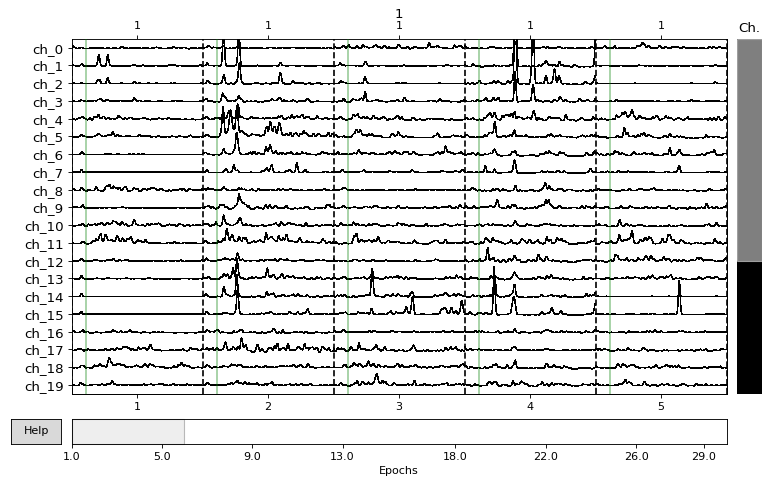

In [3]:
ecog = mne.read_epochs(feature_path + 'hfa_ecog-epo.fif', preload=True)
ecog.resample(100)
ecog.crop(tmin, tmax)

_ = ecog.plot(scalings='auto', n_epochs=5)

Once again, we'll calculate the activity in each channel and then choose the one with the largest response to speech stimuli.

In [4]:
activity = ecog.copy()
_ = mne.baseline.rescale(activity._data, activity.times, (None, 0),
                         mode='zscore', copy=False)
activity = activity._data.mean(0).mean(-1)
use_elec = np.argmax(activity)

Applying baseline correction (mode: zscore)


## Load the spectrogram feature representation
In this section, we'll focus on fitting an encoding model using a spectrogram as inputs. Here we'll load the spectrogram, resample it, and created a delayed representation of it. See the [Model Fitting](./Fitting%20Models.ipynb) notebook for details.

In [5]:
# Read in the data
spec = mne.read_epochs(feature_path + 'spectrogram-epo.fif')

# Take the log so it's more normally-distributed in each frequency band
spec._data = np.log(spec._data)

# Resample to save space
spec.resample(sfreq_new)
spec.crop(tmin, tmax)

# Create a delayed representation
delays = np.linspace(-.4, 0, 20)
X_delayed = delay_time_series(spec._data, delays, spec.info['sfreq'])
X_delayed = X_delayed.reshape(X_delayed.shape[0], -1, X_delayed.shape[-1])

Reading ../features/spectrogram-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1500.00 ...    6000.00 ms
        0 CTF compensation matrices available
29 matching events found
29 matching events found
0 projection items activated


# Cross validation
Before we dive into modeling with cross-validation, we'll take a second to explain exactly what cross validation is. The point of cross validation is to separate your data into a group used to fit models, and a group used to test the result of that fit. These are called the *training* and *test* sets, respectively.

In `scikit-learn`, we use cross validation objects in order to easily return non-overlapping sets of indices that correspond to training and test sets. If we iterate through these objects, each iteration gives us a different split.

For example, here is the result of the `ShuffleSplit` cross validation object, which creates random permutations of the data and splits it up into training / test sets.

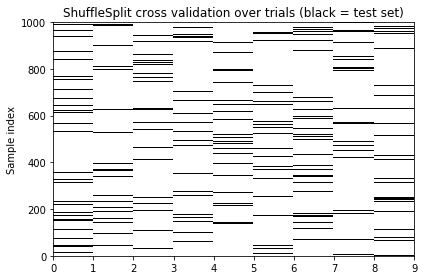

In [6]:
n_cv_iterations = 10
indices = np.arange(1000)
n_inds = indices.shape[0]
cv_example = cv.ShuffleSplit(n_inds, n_iter=n_cv_iterations)
plot_cv_indices(cv_example)

On each iteration, a random subset of indices is left out in a "test set" for that iteration. But there's a big problem with this in our case:

Many machine learning algorithms assume that data are independent and identically distributed (iid). This basically means that the value of one datapoint shouldn't *a priori* tell us anything about the other datapoints. In neuroscience, we know this isn't true. Noise from one channel spills into another, and any timeseries is autocorrelated (correlated with itself in time). As a result, it is important **not** to let datapoints with these correlations be split into training and test sets. They should stay with one another.

A good rule of thumb for timeseries analysis is "datapoints that are near one another in time should stay with one another in the analyses". One way to do this is with a "block" design that keeps datapoints roughly together in time. An easy way to do this is with something called `KFold` cross validation. 

In `KFold` cross validation, the data is broken up into `K` groups. On each iteration, one group is left out. The data is fit on the remaining groups, and then tested on the held-out group. Above you can see the blocks of data (in black) that are held out on each iteration.

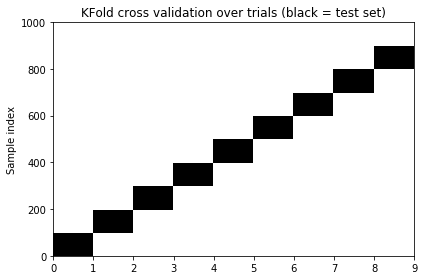

In [7]:
n_cv_iterations = 10
indices = np.arange(1000)
n_inds = indices.shape[0]
cv_example = cv.KFold(n_inds, n_folds=n_cv_iterations)
plot_cv_indices(cv_example)

As you can see, the datapoints that are near one another are grouped together in each fold. (If we didn't want this to be the case, we could use hte `shuffle` parameter to shuffle the datapoints before grouping).

However, in this case we will still split up *some* datapoints that are near one another in time (the datapoints near the boundaries of each fold). A better way to do cross validation is to iterate over stimulus presentations or trials. Assuming that there is some time between each trial, we are less likely to include dependencies between our training and test sets.

For example, below we will show the results of three cross validation routines. Instead of a range of indices that correspond to each datapoint, we'll perform this over a range of indices corresponding to each *trial*. Because these trials happen relatively far from one another in time, now we may do things like shuffling. Let's see what these three iterators looks like.

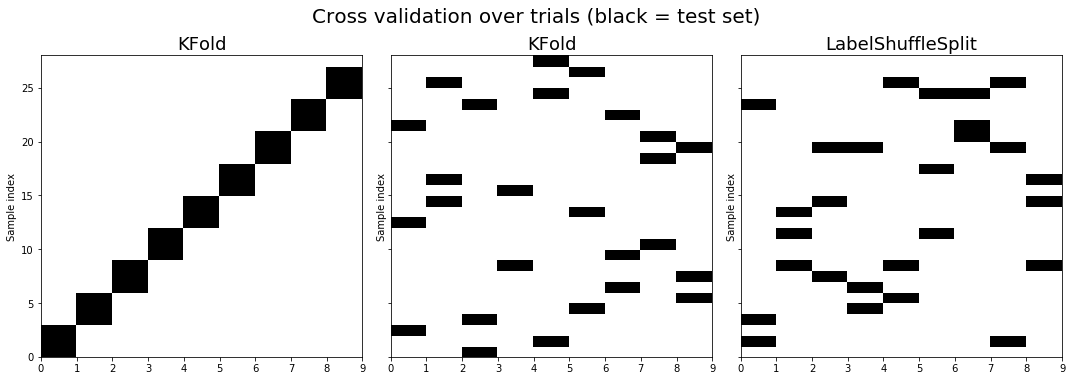

In [8]:
# Iterating across trials (labels)
trials = np.arange(len(ecog))
cv_iterators = [cv.KFold(len(trials), n_folds=n_cv_iterations),
                cv.KFold(len(trials), n_folds=n_cv_iterations, shuffle=True),
                cv.LabelShuffleSplit(trials, n_iter=n_cv_iterations,
                                     test_size=.1)]

fig, axs = plt.subplots(1, len(cv_iterators), figsize=(15, 5),
                        sharey=True, sharex=True)
for ax, icv in zip(axs, cv_iterators):
    ax = plot_cv_indices(icv, ax)
    ax.set_title(type(icv).__name__, fontsize=18)
fig.suptitle('Cross validation over trials (black = test set)',
             fontsize=20, y=1.05)
plt.tight_layout()

Each of these cross validation iterators behaves a little differently. The first blocks continuous trials together. The second shuffles the trial numbers then blocks them together. The third simply takes a random sample of trials on each iteration (meaning that some trials might be in the test set on multiple iterations).

## Using cross validation to fit our model
Now, let's use these cross validation routines to fit our model. We will iterate through one cross validation object, fit a model on a subset of trials, and then use that model to predict the high-frequency activity on the test set of trials. We'll plot the true (in grey) and the predicted (in red) high-frequency activity for each iteration, along with the score on the held-out test data for that iteration.

In [9]:
# Times to use in fitting
mask_time = mne.utils._time_mask(ecog.times, -.2, 4)

# We'll create the delays for the spectrogram ahead of time
X_delayed = delay_time_series(spec._data, delays, spec.info['sfreq'])
X = X_delayed.reshape(X_delayed.shape[0], -1, X_delayed.shape[-1])
X = X[..., mask_time]
y = ecog._data[:, use_elec, :][..., mask_time]

# We'll use the KFold iterator, shuffling trial numbers first
cross_val_iterator = cv.KFold(len(trials), n_folds=5, shuffle=True)
model = Ridge(alpha=1e5)

Let's visualize how this cross-validation object will index our data on each iteration:

* Each column is an iteration of the outer-loop of cross validation
* Red points represent testing data
* Blue points represent training data
* Shades of blue represent the validation data for each inner-loop (e.g. used to tune hyperparameters)

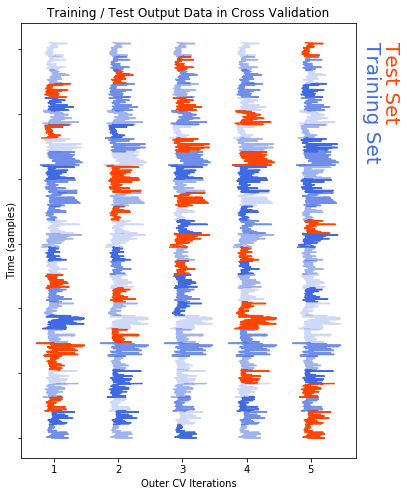

In [30]:
fig, ax = plt.subplots(figsize=(6, 8))
y_plt = scale(y)
for ii, (tr, tt) in enumerate(cross_val_iterator):
    # Here we'll define the inner-loop cross validator, which would be used to tune hyperparamters
    # For each inner loop iteration, we'll shade the validation set slightly lighter
    cv_inner = cv.KFold(len(tr), n_folds=4, shuffle=True)
    alphas = np.ones(len(trials))
    for (val_tr, val_tt), trans in zip(cv_inner, [.25, .50, .75, 1.]):
        alphas[tr[val_tt]] = trans
        
    # Now create colors according to training / test sets
    colors = np.zeros(y.shape[0]).astype(bool)
    colors[tt] = True
    colors = np.where(colors, 'orangered', 'royalblue')

    # Make the plot
    for jj, (col, alpha, i_data) in enumerate(zip(colors, alphas, y_plt)):
        ixs = np.arange(len(i_data)) + jj * y_plt.shape[-1]
        i_plt = i_data + ii * 10
        ax.plot(i_plt, ixs, c=col, alpha=alpha)
ax.set_xlabel('Outer CV Iterations')
ax.set_xticklabels(range(len(cross_val_iterator) + 1))
ax.set_title('Training / Test Output Data in Cross Validation')
ax.set_ylabel('Time (samples)')
ax.text(48, ixs.min(), 'Training Set', color='royalblue',
        rotation=-90, fontsize=20, horizontalalignment='left')
ax.text(51, ixs.min(), 'Test Set', color='orangered',
        rotation=-90, fontsize=20, horizontalalignment='left')
ax.axis('tight')
_ = plt.setp(ax.get_yticklabels(), visible=False)

As you can see, each iteration chooses a different subset of trials for use in the cross-validation. You can try making the same plot with different cross-validation iterators to see how they affect the outcome. (note that here the y-axis is time, matching the shape that scikit-learn expects as inputs)

Now, we'll use this cross validation iterator to fit a model, and test it on held-out data.

0.121594731554
0.113264952172
0.0926700368194
0.109197868229
0.11568692606


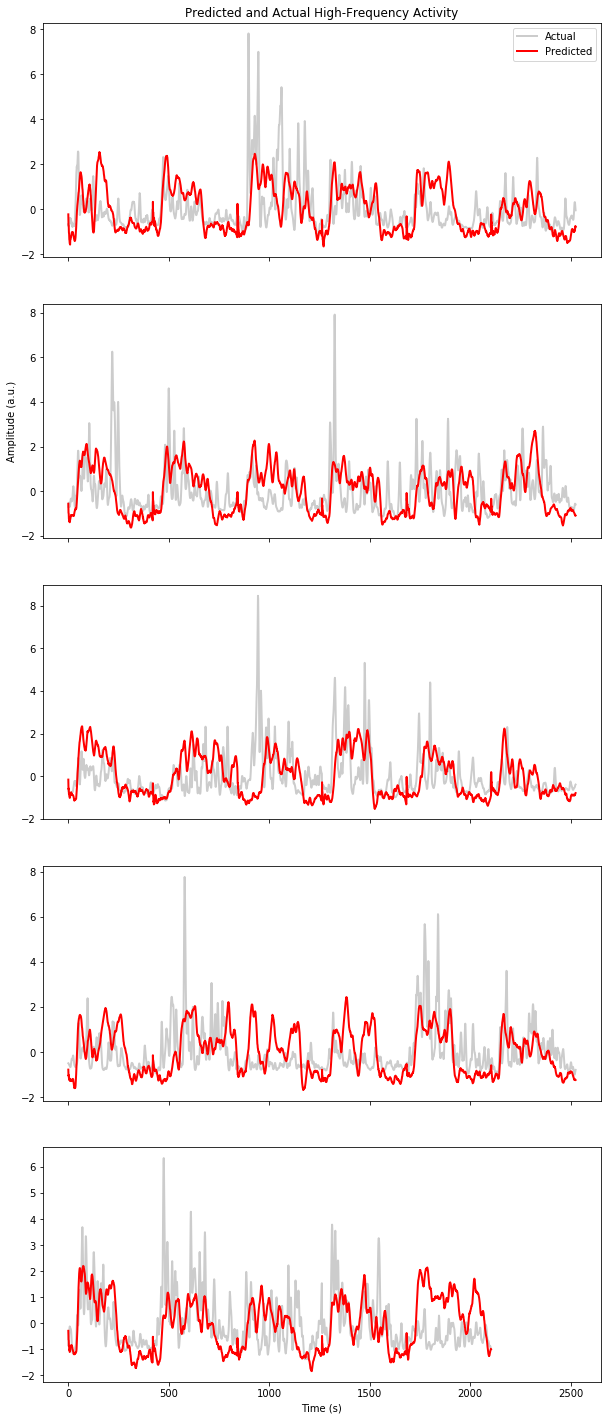

In [13]:
fig, axs = plt.subplots(len(cross_val_iterator), 1,
                        figsize=(10, 5*len(cross_val_iterator)),
                        sharex=True)
axs[0].set_title('Predicted and Actual High-Frequency Activity')
axs[1].set_ylabel('Amplitude (a.u.)')
axs[-1].set_xlabel('Time (s)')

# Iterate through cross-validation splits
for ax, (tr, tt) in zip(axs, cross_val_iterator):
    # Pull the training / testing data for the ecog data
    y_tr = np.hstack(y[tr]).T    
    y_tt = np.hstack(y[tt]).T

    # Pull the training / testing data for the spectrogram
    X_tr = np.hstack(X[tr]).T
    X_tt = np.hstack(X[tt]).T
    
    # Scale all the features for simplicity
    X_tr = scale(X_tr)
    X_tt = scale(X_tt)
    y_tr = scale(y_tr)
    y_tt = scale(y_tt)
    
    # Fit the model, and use it to predict on new data
    model.fit(X_tr, y_tr)
    predictions = model.predict(X_tt)
    
    # Plot the predicted and actual values.
    # We'll subtract the mean from each so it's easier to visualize
    ax.plot(scale(y_tt), color='k', alpha=.2, lw=2)
    ax.plot(scale(predictions), color='r', lw=2)
    ax.axis('tight')
    
    # Finally, plot the coefficient of determination (R2)
    print(r2_score(y_tt, predictions))

_ = axs[0].legend(['Actual', 'Predicted'])

As we can see, the predictions are never perfect, but they do seem to capture some degree of the variability of the true recorded ECoG signal. We can also repeat this procedure for multiple electrodes. We'll only do a single cross-validation loop for each electrode to save time. By visualizing the prediction score for each electrode we get a feel for which regions of the brain are well-modeled by spectro-temporal features.

In [14]:
# In this case, we'll keep all the electrodes
y_map = ecog._data[..., mask_time]
tr, tt = next(iter(cross_val_iterator))

# Pull the training / testing data for the ecog data
y_tr = np.hstack(y_map[tr]).T    
y_tt = np.hstack(y_map[tt]).T

# Pull the training / testing data for the spectrogram
X_tr = np.hstack(X[tr]).T
X_tt = np.hstack(X[tt]).T

# Scale all the features for simplicity
X_tr = scale(X_tr)
X_tt = scale(X_tt)
y_tr = scale(y_tr)
y_tt = scale(y_tt)

# Fit the model, and use it to predict on new data
model.fit(X_tr, y_tr)
predictions = model.predict(X_tt)
scores = r2_score(y_tt, predictions)

In [15]:
scores = []
for y_true, y_pred in zip(y_tt.T, predictions.T):
    scores.append(r2_score(y_true, y_pred))

In [16]:
im = plt.imread(raw_path + 'brain.png')
melec = pd.read_csv(raw_path + 'meta_elec.csv')
xy = melec[['x_2d', 'y_2d']].values

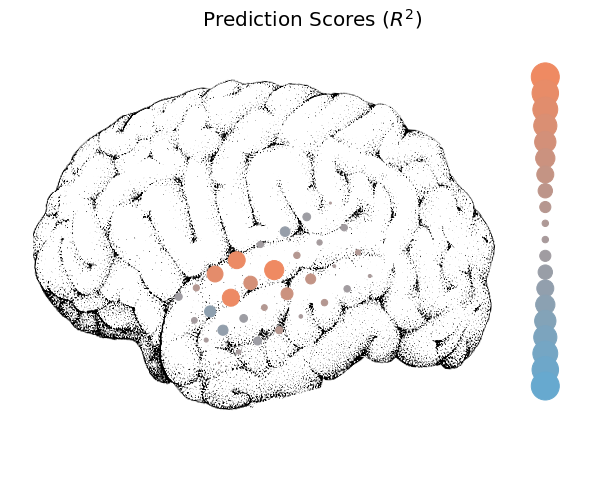

In [17]:
ax = modelingtools.plot_activity_on_brain(scores, im, xy[:, 0], xy[:, 1],
                                          size_scale=3000, vmin=-.1, vmax=.1,
                                          cmap=modelingtools.cmap_score)
ax.figure.set_size_inches(10, 10)
ax.set_title('Prediction Scores ($R^2$)', fontsize=20)

# Using cross-validation to fit a hyperparameter
You may have noticed that throughout these tutorials we have used a relatively arbitrary regularization parameter when fitting models. It is possible to use a more rigorous method for finding the correct parameter to use. This entails an extra cross-validation loop within the training set of data (called an *inner loop*).

Below, we'll use an inner loop to fit a model with a range of ridge parameters, and we can see the effect that this has on the model scores.

*Note: This might take a minute or two...*

In [18]:
# Choose some log-spaced values for alpha
alphas = np.logspace(1, 8, 8)
n_cv_outer = 3
n_cv_inner = 3

In [19]:
# This is our outer loop iterator
outer_iterator = cv.KFold(len(trials), n_folds=n_cv_outer, shuffle=True)
scores, coefs = cross_validate_alpha(X, y, outer_iterator, alphas)

[........................................] 100.00000 |    

On each iteration, we fit and scored the model for a range of alpha parameters. We can take the average score of each alpha parameter, and see how they compare to one another.

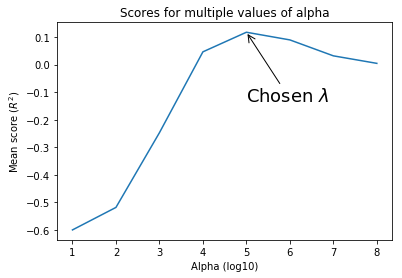

In [20]:
# Calculate the mean score across CV iterations (both inner and outer)
mean_scores = scores.mean(0).mean(0)

# Plot these values
fig, ax = plt.subplots()
ax.plot(np.log10(alphas), mean_scores)
ix_max = np.argmax(mean_scores)
ann_plt = (np.log10(alphas)[ix_max], mean_scores[ix_max])
ax.annotate('Chosen $\lambda$', ann_plt, ann_plt + np.array([0, -.25]),
            arrowprops=dict(arrowstyle='->'), fontsize=18)
ax.set_xlabel('Alpha (log10)')
ax.set_ylabel('Mean score ($R^2$)')
ax.set_title('Scores for multiple values of alpha')

As we can see, there is a particular range where the ridge parameter performs best. For small ridge parameters, we get overfitting, for large ridge parameters, we smooth the coefficients by too much. The arrow points to the "sweet spot" ridge value that we should use in the rest of our analyses.

We can look at the coefficients corresponding to the best alpha parameter to see if they look reasonable:

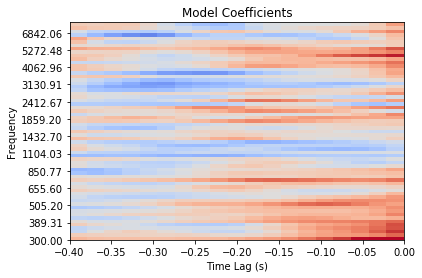

In [21]:
fig, ax = plt.subplots()
ax.pcolormesh(delays, range(len(spec.ch_names)),
              coefs.mean(0).mean(0)[ix_max, :].reshape([-1, len(delays)]),
              cmap=plt.cm.coolwarm, vmin=-.004, vmax=.004)
ax.set_yticks(np.arange(len(spec.ch_names))[::5])
ax.set_yticklabels(spec.ch_names[::5])
ax.axis('tight')
ax.set_title('Model Coefficients')
ax.set_xlabel('Time Lag (s)')
ax.set_ylabel('Frequency')

## Aside: what happens if we don't split by trials?
Now we'll see what happens when we split correlated datapoints into the training / test sets. To avoid re-working a bunch of code, we will artificially shuffle the datapoints associated with each trial / time pair. 

By shuffling these points, it will act as if the data were randomly permuted first before being split into trials. If the datapoints are IID, then this shouldn't make any difference in the outcome of the cross validation. If the data points are not IID (if there are autocorrelations in the data), then there will be some timepoints in the training set that are correlated with timepoints in the test set. The result should be a different selected ridge parameter.

In [22]:
# Create random pairs of trials / timepoints and shuffle all the data
# Note that this *shouldn't* change anything if the data is IID (it's not tho)
y_bad = y.copy()
X_bad = X.copy()
ixs = np.array(list(product(range(y_bad.shape[0]), range(y_bad.shape[-1]))))
rand_sample = np.random.permutation(range(len(ixs)))
ixs_rand = ixs[rand_sample]

for (ii_old, jj_old), (ii_new, jj_new) in zip(ixs, ixs_rand):
    y_bad[ii_new, jj_new] = y[ii_old, jj_old] 
    X_bad[ii_new, :, jj_new] = X[ii_old, :, jj_old] 

In [23]:
scores_bad, coefs_bad = cross_validate_alpha(X_bad, y_bad,
                                             outer_iterator, alphas)

[........................................] 100.00000 |    

Let's take a look at how the scores are distributed across alpha parameters now...

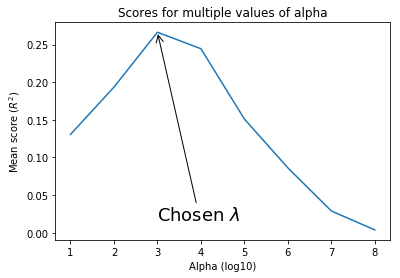

In [24]:
# Calculate the mean score across CV iterations for each alpha
mean_scores = scores_bad.mean(1).mean(0)

# Plot these values
fig, ax = plt.subplots()
ax.plot(np.log10(alphas), mean_scores)
ix_max = np.argmax(mean_scores)
ann_plt = (np.log10(alphas)[ix_max], mean_scores[ix_max])
ax.annotate('Chosen $\lambda$', ann_plt, ann_plt + np.array([0, -.25]),
            arrowprops=dict(arrowstyle='->'), fontsize=18)
ax.set_xlabel('Alpha (log10)')
ax.set_ylabel('Mean score ($R^2$)')
ax.set_title('Scores for multiple values of alpha')

As you can see, the cross-validation scores are now best for the lower alpha values. This is because the model picks up on the correlations between the training / test sets, and overfits to these correlations rather than to the true underlying relationships between the datasets. Let's look at the coefficients averaged across CVs:

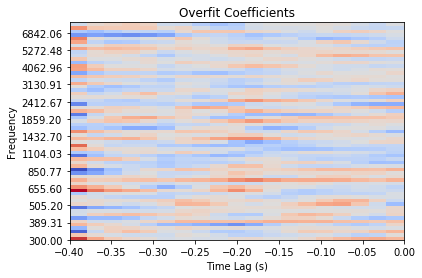

In [25]:
fig, ax = plt.subplots()
ax.pcolormesh(delays, range(len(spec.ch_names)),
              coefs_bad.mean(0).mean(0)[ix_max, :].reshape([-1, len(delays)]),
              cmap=plt.cm.coolwarm)
ax.set_yticks(np.arange(len(spec.ch_names))[::5])
ax.set_yticklabels(spec.ch_names[::5])
ax.axis('tight')
ax.set_title('Overfit Coefficients')
ax.set_xlabel('Time Lag (s)')
ax.set_ylabel('Frequency')

There isn't any discernible structure to these coefficients, even though the model was doing a pretty good job of predicting on the test set. Any time you see a well-performing model, but the coefficients look indecipherable, there's a good chance that something fishy is going on. Be on the lookout for these kinds of problems when performing cross-validation.

# Prediction / Validation in Decoding
For decoding, we will focus on the problem of classification. This is because prediction / validation in decoding models is very similar to the same process in encoding models. Classification poses a different challenge than regression, because outputs cannot be scored using metrics like regression. A classification model is not scored on its ability to explain variance in a test set, but to accurately predict the correct class. As such, the metrics for scoring, and the nature of a model's predictions, look slightly different.

Below we will focus on the problem of classifying vowels from plosives, two phoneme types that have very different spectral features.

In [4]:
# Pull ECoG phoneme data
phonemes = mne.read_epochs(feature_path + 'ecog_phonemes-epo.fif')
phoneme_labels = pd.read_csv(raw_path + 'phoneme_labels.csv', index_col=0)
phoneme_labels = phoneme_labels.query('phoneme in @phonemes.event_id.keys()')

# Define our targets
target_ph = ['vowels']
non_target_ph = ['plosives']
phonemes_targets = phoneme_labels.query('kind in @target_ph')['phoneme'].values
phonemes_non_targets = phoneme_labels.query('kind in @non_target_ph')['phoneme'].values

# Only include the epochs that include one of our phonemes of choice
ecog_targets = phonemes[list(phonemes_targets)]._data.mean(-1)
ecog_non_targets = phonemes[list(phonemes_non_targets)]._data.mean(-1)

# Now binarize the phoneme labels so we can classify
labels_targets = np.ones(ecog_targets.shape[0])
labels_non_targets = np.zeros(ecog_non_targets.shape[0])

X = np.vstack([ecog_targets, ecog_non_targets])
y = np.hstack([labels_targets, labels_non_targets])

Reading ../features/ecog_phonemes-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...      73.33 ms
        0 CTF compensation matrices available
982 matching events found
982 matching events found
0 projection items activated


In this case, we'll use a *stratified* cross validation iterator. This is an iterator which ensures that the ratio of classes is the same in each CV iteration. This is important if there are imbalanced numbers of samples in each class (think of an extreme case where there are 3 samples of type A, and 100 samples of type B...most iterations would have no examples of type A, so this accounts for that).

We will use a non-linear model for classifying called a Random Forest. These are much harder to interpret, but are generally both faster and more powerful for doing well on testing data.

In [27]:
# Define our CV and model
cv_classify = cv.StratifiedShuffleSplit(y, n_iter=100, test_size=.1)
model = RandomForestClassifier()

# This is the ratio of targets to non targets
ratio_targets = float(np.sum(y)) / y.shape[0]
print(ratio_targets)

0.47104247104247104


In [28]:
# Loop through CV iterations
# fit the model and predict the class of testing data
all_predictions = []
all_true = []
for tr, tt in cv_classify:
    y_tr = y[tr]
    y_tt = y[tt]
    
    X_tr = X[tr]
    X_tt = X[tt]
    
    # Only scale X, since y is a label
    X_tr = scale(X_tr)
    X_tt = scale(X_tt)
    
    model.fit(X_tr, y_tr)
    predictions = model.predict_proba(X_tt)
    all_predictions.append(predictions)
    all_true.append(y_tt)

We now have a collection of predictions for each cross validation iteration. For each set of predictions, we can calculate its Area Under the Curve. We'll use a scikit-learn helper function to do this automatically:

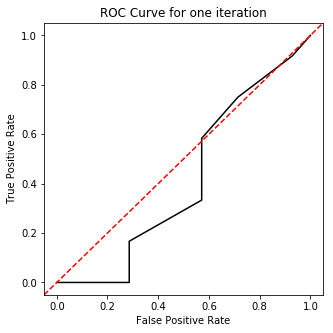

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
fpr, tpr, thresholds = roc_curve(all_true[0], all_predictions[0][:, 0],
                                 pos_label=1)
ax.plot(fpr, tpr, color='k')
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--', color='r')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for one iteration')

As we can see, this iteration didn't do very well. In an ideal case, the True Positive Rate will be much larger than the False Positive Rate. Here we see that the opposite is true. However, classification can be quite noisy, especially with limited data points and non-linear classifiers. Let's look at how all of our cross-validated performance looks:

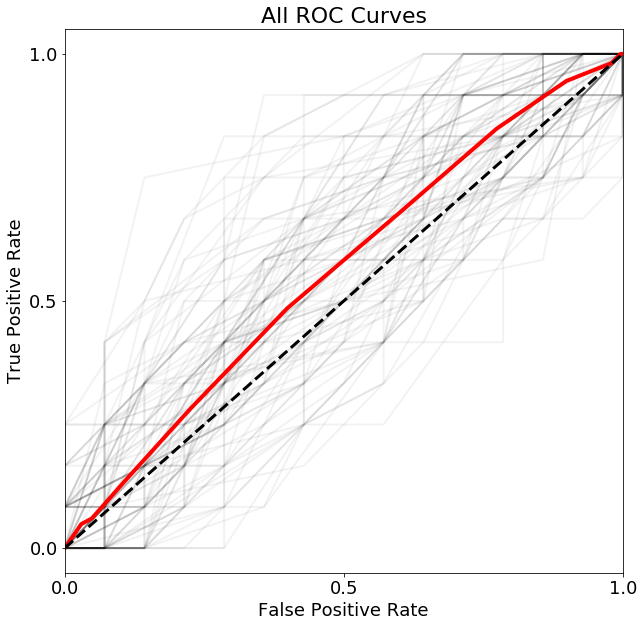

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
results = []
scores = []
scores_chance = []
for i_true, i_pred in zip(all_true, all_predictions):
    fpr, tpr, thresholds = roc_curve(i_true, i_pred[:, 0], pos_label=1)
    score = roc_auc_score(i_true, i_pred[:, 0])
    score_chance = roc_auc_score(i_true, np.repeat(ratio_targets, len(i_true)))
    df = pd.DataFrame.from_dict({'fpr': fpr, 'tpr': tpr, 'thresh': thresholds})
    results.append(df)
    scores.append(score)
    scores_chance.append(score_chance)
    ax.plot(fpr, tpr, alpha=.05, color='k', lw=2)
results = pd.concat(results)
results['thresh_rnd'] = results['thresh'].round(2)
av_results = results.groupby('thresh_rnd').mean().sort_values('fpr')
av_results.plot('fpr', 'tpr', ax=ax, color='r', lw=4, label='average ROC')
ax.plot((0, 1), (0, 1), ls='--', color='k', lw=3)
ax.set_xticks([0, .5, 1])
ax.set_yticks([0, .5, 1])
_ = plt.setp(ax.get_xticklabels() + ax.get_yticklabels() +
             [ax.xaxis.label, ax.yaxis.label], fontsize=18)
ax.get_legend().set_visible(False)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('All ROC Curves', fontsize=22)

Again, this looks messy. Maybe the curve is above the 50/50 line, maybe not. To determine this we would need to calculate the area under the curve for each iteration, and see if it differed significantly from chance levels.

We'll give this a shot by bootstrapping confidence intervals around the mean of the AUC values. For each bootstrap iteration, we'll take a random sample of AUC scores, and calculate its mean. We'll repeat this 1000 times, and then calculate the .5th and 99.5th percentiles of this distribution.

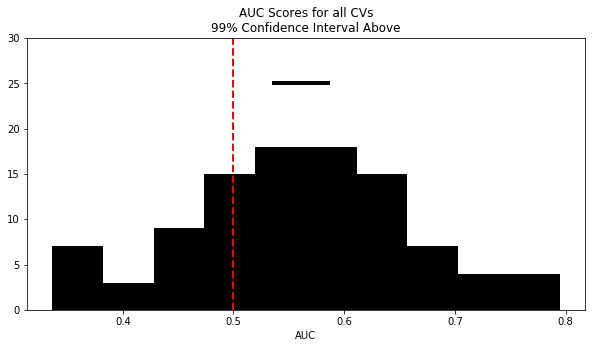

In [31]:
# Create the confidence intervals w/ a bootstrap
random_means = [np.mean(np.random.choice(scores, len(scores)))
                for _ in range(1000)]
lo, hi = np.percentile(random_means, [.5, 99.5])

fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.axvline(.5, ls='--', color='r', lw=2)
_ = ax.hist(scores, color='k')
_ = ax.hlines(25, lo, hi, lw=4)
ax.set_ylim([0, 30])
ax.set_title('AUC Scores for all CVs\n99% Confidence Interval Above')
ax.set_xlabel('AUC')

As you can see it's pretty close...the confidence interval is *just* at chance level, and would probably overlap with it at some point given enough repetitions of the above process. Is that a "significant" result? There's no single answer to this question, but especially for results that are on the edge of significance, there should be a compelling reason for treating it as such.

## Confusion matrices
Finally, if we are performing multi-class classification, then it is common to create a *confusion matrix* in order to visualize how classes are confused with one another in the model. `scikit-learn` also has a convenient way for doing this.

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
# Set up some variables that let us define targets for each phoneme
rev_event_id = {value: key for key, value in phonemes.event_id.items()}

# We'll classify the phoneme class so we have fewer total classes
label_mapping = {ph: kind for kind, ph in phoneme_labels.values}

# These are integers, one for each class
targets = np.array([rev_event_id[ii] for ii in phonemes.events[:, -1]])
targets = np.array([label_mapping.get(ii, None) for ii in targets])

In [7]:
# Calculate the mean electrode activity just after each phoneme as input
X = phonemes._data.mean(-1)

# Remove phonemes we don't want
include_targets = ['fricatives', 'nasals', 'plosives', 'vowels']
mask_use = [target in include_targets for target in targets.astype(str)]
X = X[mask_use]
targets = targets[mask_use]
df_labels = np.unique(targets)

Finally, we'll fit a classifier for each unique target. It will attempt to classify that target vs. all other classes. It will then validate the model fit in this way by counting the accuracy for all non-targets. As a result, we have a confusion matrix.

In [8]:
# Instantiate the model + cross validation
model = RandomForestClassifier(n_estimators=20)
cv = StratifiedShuffleSplit(test_size=0.05, n_splits=10)

# Matrices will store the confusion matrix for each CV iteration
# It will count false classifications for each phoneme
matrices = []
for train, test in cv.split(X, targets):
    model.fit(X[train], targets[train])
    predictions = model.predict(X[test])
    matrix = confusion_matrix(targets[test], predictions,
                              labels=df_labels)
    matrix = matrix / matrix.sum(-1)  # Divide by total "true" classes for this iteration to gat a %
    matrices.append(matrix)
matrix = np.array(matrices).mean(0)

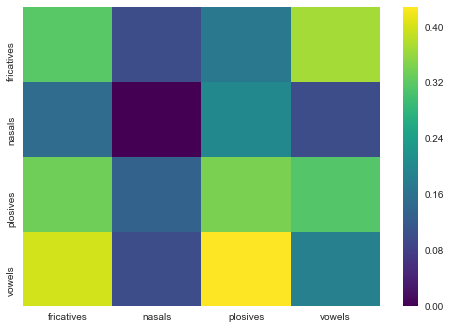

In [33]:
# Now we'll show the heatmap
matrix = pd.DataFrame(matrix, index=df_labels, columns=df_labels)
ax = sns.heatmap(matrix, cmap='viridis')

As you can see above, this is actually not a very good result - ideally we'd see a nice diagonal line, indicating that samples were correctly classified as their true class.